# Low Noise Models - Overview  - FinalFinal

In [1]:
from obspy import * 
from pandas import *
from os import listdir
from scipy.stats import median_absolute_deviation as mad

import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def __cut_frequencies_dataframe(df_psd, fmin, fmax):
    ind = []
    for i,f in enumerate(df_psd['frequencies']):
        if f >= fmin and f <= fmax:
            ind.append(i)

    df = df_psd.iloc[ind[0]:ind[-1],:]

    return df

In [3]:
def __conversion(data, informat=None, outformat=None):
    '''
    data:                  array 
    informat/outformat:    ASD, PSD, DB
    '''
    from numpy import log10, sqrt
    
    
    if informat == 'ASD' and outformat == 'PSD':
        return data**2
    
    elif informat == 'PSD' and outformat == 'ASD':
        return sqrt(data)

    elif informat == 'ASD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'PSD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'DB' and outformat == 'PSD':
        return 10**(data/10)
    
    elif informat == 'DB' and outformat == 'ASD':
        return sqrt(10**(data/10))
    
    else:
        print(" -> specified case not defined!")

## Configurations

In [4]:
config = {}

config['workdir'] = "/export/data/LNM/data/"

config['year'] = "2018"
config['datadir_spectra'] = config['workdir']+config['year']+"/"

config['outdir_figures'] = "/home/brotzer/Documents/ROMY/LowNoiseModel/figures/"

config['spectra_files'] = listdir(config['datadir_spectra'])

# config['outdir'] = config['workdir']+"STATS/"

### Load RLNM Theory

In [5]:
rlnm = read_csv(config['workdir']+"MODELS/"+"rlnm_theory.csv")

periods = rlnm['period']
rlnm_psd = rlnm['rlnm_psd_median']
rlnm_psd_max = rlnm['rlnm_psd_maximum']
rlnm_upper_psd = rlnm['rlnm_psd_upper']
rlnm_lower_psd = rlnm['rlnm_psd_lower']

In [6]:
rlnm_db       = __conversion(rlnm_psd, informat='PSD', outformat='DB')
rlnm_upper_db = __conversion(rlnm_upper_psd, informat='PSD', outformat='DB')
rlnm_lower_db = __conversion(rlnm_lower_psd, informat='PSD', outformat='DB')

### RLAS Data

In [7]:
rlas = read_pickle(config['workdir']+"STATS/"+"2019_RLAS-Z_hours_stats.pkl")

In [8]:
rlas_select = read_pickle(config['workdir']+"STATS/"+"2019_RLAS-Z_hours_select_stats.pkl")

### Load ROMY

In [9]:
romy_z = read_pickle(config['workdir']+"STATS/"+"2019_ROMY-Z_hours_stats.pkl")

In [10]:
romy_z_select = read_pickle(config['workdir']+"STATS/"+"2019_ROMY-Z_hours_select_stats.pkl")

In [11]:
romy_u = read_pickle(config['workdir']+"STATS/"+"2019_ROMY-U_hours_stats.pkl")
romy_v = read_pickle(config['workdir']+"STATS/"+"2019_ROMY-V_hours_stats.pkl")
romy_w = read_pickle(config['workdir']+"STATS/"+"2019_ROMY-W_hours_stats.pkl")

### Load PFO Data

In [12]:
datapath = "/import/kilauea-data/ROMY/RotationSpectra/data/"

data_pfo_N = "run_2019_RPFO-N_3600/run_2019_RPFO-N_3600_stats.pkl"
data_pfo_E = "run_2019_RPFO-E_3600/run_2019_RPFO-E_3600_stats.pkl"
data_pfo_Z = "run_2019_RPFO-Z_3600/run_2019_RPFO-Z_3600_stats.pkl"

PFO_N = read_pickle(datapath+data_pfo_N)
PFO_E = read_pickle(datapath+data_pfo_E)
PFO_Z = read_pickle(datapath+data_pfo_Z)

fmin, fmax = 1/50, 1.0
PFO_N = __cut_frequencies_dataframe(PFO_N, fmin, fmax)
PFO_E = __cut_frequencies_dataframe(PFO_E, fmin, fmax)
PFO_Z = __cut_frequencies_dataframe(PFO_Z, fmin, fmax)

PFO_N_median_psd = PFO_N['median']
PFO_E_median_psd = PFO_E['median']
PFO_Z_median_psd = PFO_Z['median']

PFO_N_minimal_psd = PFO_N['minimal']
PFO_E_minimal_psd = PFO_E['minimal']
PFO_Z_minimal_psd = PFO_Z['minimal']

### Load GRF ADR

In [13]:
datapath = "/import/kilauea-data/ROMY/RotationSpectra/data/"

GRF_array = "GRA2"

data_grf_N = f"run_2019_RGRF-N_3600_{GRF_array}/run_2019_RGRF-N_3600_{GRF_array}_stats.pkl"
data_grf_E = f"run_2019_RGRF-E_3600_{GRF_array}/run_2019_RGRF-E_3600_{GRF_array}_stats.pkl"
data_grf_Z = f"run_2019_RGRF-Z_3600_{GRF_array}/run_2019_RGRF-Z_3600_{GRF_array}_stats.pkl"

GRF_N = read_pickle(datapath+data_grf_N)
GRF_E = read_pickle(datapath+data_grf_E)
GRF_Z = read_pickle(datapath+data_grf_Z)

GRF_N_median_psd = GRF_N['median']
GRF_E_median_psd = GRF_E['median']
GRF_Z_median_psd = GRF_Z['median']

GRF_N_minimal_psd = GRF_N['minimal']
GRF_E_minimal_psd = GRF_E['minimal']
GRF_Z_minimal_psd = GRF_Z['minimal']

### Load Single Station Model

In [14]:
ssm = read_pickle(config['workdir']+"STATS/"+"station_2019_derived_rlnm.pkl")

## cutoff first samples
ssm = ssm.iloc[:-10,:]

ssm['frequencies'] = 1/ssm['period']

fmin, fmax = 1/200, 3.0
ssm = __cut_frequencies_dataframe(ssm, fmin, fmax)

ssm_period = ssm['period']
ssm_median_psd = ssm['median']
ssm_minimal_psd = ssm['minimal']

ssm_median_psd = __conversion(ssm['median'], informat="ASD", outformat="PSD")
ssm_minimal_psd = __conversion(ssm['minimal'], informat="ASD", outformat="PSD")

### Load ROMY-V 2022

In [15]:
romy_v = read_pickle(config['workdir']+"STATS/"+"2022_ROMY-V_stats.pkl")

romy_v_median_psd = romy_v['psds_median']
romy_v_minimal_psd = romy_v['psds_minimal']

FileNotFoundError: [Errno 2] No such file or directory: '/export/data/LNM/data/STATS/2022_ROMY-V_stats.pkl'

### Load ROMY ADR 2019

In [31]:
datapath = "/import/kilauea-data/ROMY/RotationSpectra/data/"

RMY_ADR_Z = read_pickle(datapath+"run_2019_ROMY_ADR-Z_3600_all/run_2019_ROMY_ADR-Z_3600_all_stats.pkl")
RMY_ADR_N = read_pickle(datapath+"run_2019_ROMY_ADR-N_3600_all/run_2019_ROMY_ADR-N_3600_all_stats.pkl")
RMY_ADR_E = read_pickle(datapath+"run_2019_ROMY_ADR-E_3600_all/run_2019_ROMY_ADR-E_3600_all_stats.pkl")

## cut at 50 seconds
RMY_ADR_Z = RMY_ADR_Z[RMY_ADR_Z['frequencies'] > 1/40]
RMY_ADR_N = RMY_ADR_N[RMY_ADR_N['frequencies'] > 1/40]
RMY_ADR_E = RMY_ADR_E[RMY_ADR_E['frequencies'] > 1/40]

RMY_ADR_Z_median_psd = RMY_ADR_Z['median']
RMY_ADR_N_median_psd = RMY_ADR_N['median']
RMY_ADR_E_median_psd = RMY_ADR_E['median']

RMY_ADR_Z_minimal_psd = RMY_ADR_Z['minimal']
RMY_ADR_N_minimal_psd = RMY_ADR_N['minimal']
RMY_ADR_E_minimal_psd = RMY_ADR_E['minimal']


### Load RLNM Distribution

In [17]:
import pickle

with open(config['workdir']+"MODELS/"+"RLNM_distribution.pkl",'rb') as f:
    output = pickle.load(f)

## Plot Overview - Median

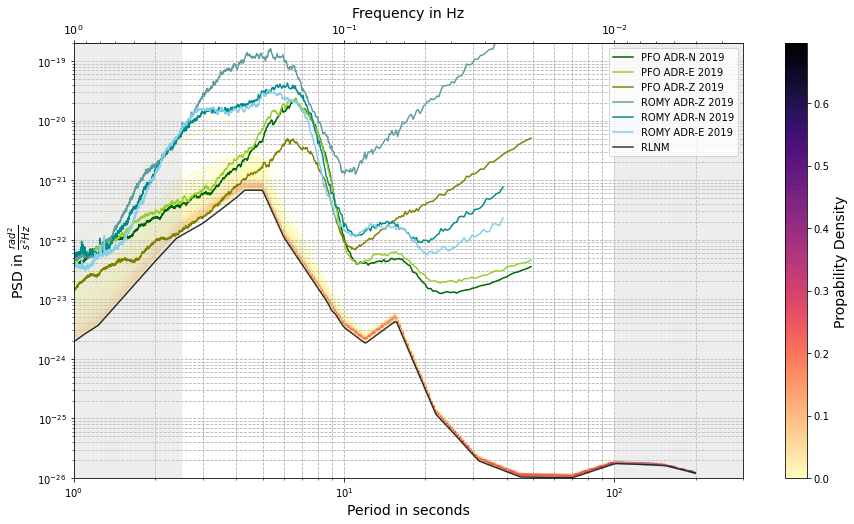

In [34]:
def __plot_rlnm_median_overview():
    
    font = 14

    fig, ax = plt.subplots(1,1,figsize=(15,8))

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
    ax2.set_xticklabels(1/periods, fontsize=11)
    
    ## single stations model
#     plt.plot(ssm_period, ssm_median_psd, color="purple", zorder=2, label="Single-Stations 2019")
        

    ## PFO ADR data
    plt.plot(1/PFO_N['frequencies'], PFO_N_median_psd, color="darkgreen", zorder=2, label="PFO ADR-N 2019")
    plt.plot(1/PFO_E['frequencies'], PFO_E_median_psd, color="yellowgreen", zorder=2, label="PFO ADR-E 2019")
    plt.plot(1/PFO_Z['frequencies'], PFO_Z_median_psd, color="olive", zorder=2, label="PFO ADR-Z 2019")
    
    ## GRF ADR data
#     plt.plot(1/GRF_N['frequencies'], GRF_N_median_psd, color="sienna", zorder=2, label=f"{GRF_array} ADR-N 2019")
#     plt.plot(1/GRF_E['frequencies'], GRF_E_median_psd, color="tan", zorder=2, label=f"{GRF_array} ADR-E 2019")
#     plt.plot(1/GRF_Z['frequencies'], GRF_Z_median_psd, color="indianred", zorder=2, label=f"{GRF_array} ADR-Z 2019")
    
    ## ROMY ADR data 2019
    plt.plot(1/RMY_ADR_Z['frequencies'], RMY_ADR_Z_median_psd, color="cadetblue", zorder=2, label="ROMY ADR-Z 2019")
    plt.plot(1/RMY_ADR_N['frequencies'], RMY_ADR_N_median_psd, color="darkcyan", zorder=2, label="ROMY ADR-N 2019")
    plt.plot(1/RMY_ADR_E['frequencies'], RMY_ADR_E_median_psd, color="skyblue", zorder=2, label="ROMY ADR-E 2019")
             
    ## romy data
#     plt.plot(1/romy_z['frequencies'], romy_z['psds_median'], color="orange", zorder=3, label="ROMY-Z 2019")
#     plt.plot(1/romy_z_select['frequencies'], romy_z_select['psds_median'], color="orange", ls="--", zorder=3, label="ROMY-Z 2019 select")
    
    ## romy others
#     plt.plot(1/romy_u['frequencies'], romy_u['psds_median'], color="pink", zorder=2, label="ROMY-U 2022")
#     plt.plot(1/romy_v['frequencies'], romy_v['psds_median'], color="hotpink", zorder=2, label="ROMY-V 2022")
#     plt.plot(1/romy_w['frequencies'], romy_w['psds_median'], color="orchid", zorder=2, label="ROMY-W 2022")
        
    ## rlas data
#     plt.plot(1/rlas['frequencies'], rlas['psds_median'], color="blue", zorder=3, label="RLAS 2019")
#     plt.plot(1/rlas_select['frequencies'], rlas_select['psds_median'], color="blue", ls="--", zorder=3, label="RLAS 2019 select")

    ## theoretical rlnm
#     plt.plot(periods, rlnm_psd, color="black", zorder=2, lw=2, label="RLNM")


    y_axis = 10**(output['bin_mids']/10)
    x_axis = output['period']

    ## plotting

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('gray_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, output['dist'].T, 
                    cmap=cmap,
                    vmin=1e-12, 
                    alpha=0.99,
                   )
    
    ## add medians 
    medians = 10**(output['bins_medians']/10)
#     plt.plot(output['period'], medians, color="black", zorder=2, lw=0.5, alpha=0.8, ls=":", label="median")
    
    ## add minimas 
    minimas = 10**(output['bins_minimum']/10)
    plt.plot(output['period'], minimas, color="black", zorder=2, lw=1.5, alpha=0.8, label="RLNM")
    
    
    ## add colorbar
    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    cb.set_label("Propability Density", fontsize=font)
    
    
    plt.xscale("log")
    plt.yscale("log")

    plt.xlim(1, 200)

    ymin, ymax = 1e-26, 2e-19
#     ymin, ymax = 1e-26, 5e-20

    plt.ylim(ymin, ymax)
   
    plt.fill_betweenx(np.linspace(ymin,ymax,5), x1=0, x2=2.5, color="lightgrey", alpha=0.4, zorder=2)
    plt.fill_betweenx(np.linspace(ymin-10,ymax+10,5), x1=100, x2=300, color="lightgrey", alpha=0.4, zorder=2)


    plt.grid(axis="both", which="both", ls="--", zorder=0)
    plt.legend()

    plt.xlabel("Period in seconds", fontsize=font)
    plt.ylabel(r"PSD in $\frac{rad^2}{s^2 Hz}$",fontsize=font)

    plt.show();
    return fig 

fig = __plot_rlnm_median_overview()

In [35]:
fig.savefig(config['outdir_figures']+"Figure3"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

In [23]:
# fig.savefig(config['outdir_figures']+"Sequence/"+"Model_Data_Overview_Median_PSD_Distribution_SEQ5"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

# fig.savefig(config['outdir_figures']+"Model_Data_Overview_Median_PSD_Distribution_ringlaser"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

## Plot Overview - Minimal

In [19]:
def __plot_rlnm_minimal_overview():
    
    font = 14

    fig, ax = plt.subplots(1,1,figsize=(15,8))

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
    ax2.set_xticklabels(1/periods, fontsize=11)
    
    ## single stations model
#     plt.plot(ssm_period, ssm_minimal_psd, color="purple", zorder=2, label="Single-Stations 2019")
        

    ## PFO data
#     plt.plot(1/PFO_N['frequencies'], PFO_N_minimal_psd, color="darkgreen", zorder=2, label="PFO ADR-N 2019")
#     plt.plot(1/PFO_E['frequencies'], PFO_E_minimal_psd, color="yellowgreen", zorder=2, label="PFO ADR-E 2019")
#     plt.plot(1/PFO_Z['frequencies'], PFO_Z_minimal_psd, color="olive", zorder=2, label="PFO ADR-Z 2019")

    ## ROMY ADR data 2022
#     plt.plot(romy_adr_z['frequencies'], romy_adr_z_minimal_psd, color="cadetblue", zorder=2, label="ROMY ADR-Z")
#     plt.plot(romy_adr_n['frequencies'], romy_adr_n_minimal_psd, color="darkcyan", zorder=2, label="ROMY ADR-N")
#     plt.plot(romy_adr_e['frequencies'], romy_adr_e_minimal_psd, color="skyblue", zorder=2, label="ROMY ADR-E")

    ## ROMY ADR data 2019
#     plt.plot(1/RMY_ADR_Z['frequencies'], RMY_ADR_Z_minimal_psd, color="cadetblue", zorder=2, label="ROMY ADR-Z 2019")
#     plt.plot(1/RMY_ADR_N['frequencies'], RMY_ADR_N_minimal_psd, color="darkcyan", zorder=2, label="ROMY ADR-N 2019")
#     plt.plot(1/RMY_ADR_E['frequencies'], RMY_ADR_E_minimal_psd, color="skyblue", zorder=2, label="ROMY ADR-E 2019")
        

    ## romy data
    plt.plot(1/romy_z['frequencies'], romy_z['psds_minimal'], color="orange", zorder=2, label="ROMY-Z 2019")
    
    # romy data 2022 march
#     plt.plot(romy_2022['frequencies'], romy_2022_median_psd, color="pink", zorder=2, label="ROMY-Z 2022")

    ## romy others
    plt.plot(1/romy_u['frequencies'], romy_u['psds_minimal'], color="pink", zorder=2, label="ROMY-U 2022")
    plt.plot(1/romy_v['frequencies'], romy_v['psds_minimal'], color="hotpink", zorder=2, label="ROMY-V 2022")
    plt.plot(1/romy_w['frequencies'], romy_w['psds_minimal'], color="orchid", zorder=2, label="ROMY-W 2022")
        

    ## rlas data
    plt.plot(1/rlas['frequencies'], rlas['psds_minimal'], color="blue", zorder=2, label="RLAS 2019")

    ## theoretical rlnm
#     plt.plot(periods, rlnm_minimal_psd, color="black", zorder=2, lw=2, label="RLNM")


    y_axis = 10**(output['bin_mids']/10)
    x_axis = output['period']

    ## plotting

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('gray_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, output['dist'].T, 
                    cmap=cmap,
                    vmin=1e-12, 
                    alpha=0.99,
                   )
    
    ## add medians 
    medians = 10**(output['bins_medians']/10)
#     plt.plot(output['period'], medians, color="black", zorder=2, lw=0.5, alpha=0.8, ls=":", label="median")
    
    ## add minimas 
    minimas = 10**(output['bins_minimum']/10)
    plt.plot(output['period'], minimas, color="black", zorder=2, lw=1.5, alpha=0.8, label="RLNM")
    
    
    ## add colorbar
    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    cb.set_label("Propability Density", fontsize=font)
    
    
    plt.xscale("log")
    plt.yscale("log")

    plt.xlim(1, 300)

    ymin, ymax = 1e-26, 5e-20
    plt.ylim(ymin, ymax)
   
    plt.fill_betweenx(np.linspace(ymin,ymax,5), x1=0, x2=2.5, color="lightgrey", alpha=0.4, zorder=2)
    plt.fill_betweenx(np.linspace(ymin-10,ymax+10,5), x1=100, x2=300, color="lightgrey", alpha=0.4, zorder=2)


    plt.grid(axis="both", which="both", ls="--", zorder=0)
    plt.legend()

    plt.xlabel("Period in seconds", fontsize=font)
    plt.ylabel(r"PSD in $\frac{rad^2}{s^2 Hz}$",fontsize=font)

    plt.show();
    return fig 

# fig = __plot_rlnm_minimal_overview()

In [18]:
# fig.savefig(config['outdir_figures']+"Sequence/"+"Model_Data_Overview_Minimal_PSD_Distribution_SEQ5"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

# fig.savefig(config['outdir_figures']+"Model_Data_Overview_Minimal_PSD_Distribution_ringlaser"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)